<a href="https://colab.research.google.com/github/shashank-kumar-rajput/Coursera_Capstone/blob/master/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Year Project : design Weather Station for Farming**





* Identifying Crop Disease
* Temperature monitoring through ThinkSpeak.
* Checking Air Quality and Humidity and monitoring through ThinkSpeak


#**Submitted By:**

*   Shashank Kumar

*   Shashank Saxena
*   Shourya Vashista
*  Arjit Jaitely
*  Shikha Singh 


#**Under the guidence of : N. R. Srivastava**
---

![alt text](https://cdn-images-1.medium.com/max/1200/1*FswlF4lZPQ4kT_gkybacZw.jpeg)


# Introduction

Getting affected by a disease is very common in plants due to various factors such as fertilizers, cultural practices followed, environmental conditions, etc. These diseases hurt agricultural yield and eventually the economy based on it. 

Any technique or method to overcome this problem and getting a warning before the plants are infected would aid farmers to efficiently cultivate crops or plants, both qualitatively and quantitatively. Thus, disease detection in plants plays a very important role in agriculture.


# Download Dataset


First, we download the `PlantVillage` dataset from Google Drive by using the unique `id` it holds and unzip the downloaded **PlantVillage.zip** into the **PlantVillage** dataset folder.

In [ ]:
# Download a file based on its file ID.
file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip the downloaded file
!unzip -q PlantVillage.zip

Downloading...
From: https://drive.google.com/uc?id=18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn
To: /content/PlantVillage.zip
866MB [00:05, 148MB/s]


# Import Libraries


Importing necessary libraries and modules required to build the classification model.

In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Load Dataset

Initializing a few parameters required for the image dataset preprocessing.

In [ ]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = './PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above.

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Here, we load the training data images by traversing through all the folders and converting all the images and labels into separate lists respectively.

*NOTE: We use a small portion of the entire dataset due to the computing limitations. Tweak `N_IMAGES` to include entire dataset.*

In [ ]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Soybean___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Pepper,_bell___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Squash___Powdery_mildew ...
[INFO] Processing Strawberry___healthy ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Apple___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Strawberry___Leaf_scorc

Examine the labels/classes in the training dataset.

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  39


# Augment and Split Dataset

Using `ImageDataGenerator` to augment data by performing various operations on the training images.

In [ ]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

Splitting the data into training and test sets for validation purpose.

In [ ]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


# Build Model


Defining the hyperparameters of the plant disease classification model.

In [ ]:
EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.

In [ ]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)       

# Train Model


We initialize Adam optimizer with learning rate and decay parameters. 

Also, we choose the type of loss and metrics for the model and compile it for training.

In [ ]:
# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

[INFO] Training network...
Epoch 1/25
97/97 [==============================] - 792s 8s/step - loss: 0.0964 - accuracy: 0.9739 - val_loss: 0.3557 - val_accuracy: 0.9499
Epoch 2/25
97/97 [==============================] - 778s 8s/step - loss: 0.0852 - accuracy: 0.9749 - val_loss: 0.3076 - val_accuracy: 0.9669
Epoch 3/25
97/97 [==============================] - 793s 8s/step - loss: 0.0718 - accuracy: 0.9775 - val_loss: 0.3322 - val_accuracy: 0.9549
Epoch 4/25
97/97 [==============================] - 788s 8s/step - loss: 0.0576 - accuracy: 0.9813 - val_loss: 0.1837 - val_accuracy: 0.9626
Epoch 5/25
97/97 [==============================] - 791s 8s/step - loss: 0.0575 - accuracy: 0.9809 - val_loss: 0.0760 - val_accuracy: 0.9767
Epoch 6/25
97/97 [==============================] - 802s 8s/step - loss: 0.0500 - accuracy: 0.9830 - val_loss: 0.1289 - val_accuracy: 0.9714
Epoch 7/25
97/97 [==============================] - 795s 8s/step - loss: 0.0520 - accuracy: 0.9828 - val_loss: 0.1049 - val_acc

# Evaluate Model

Comparing the accuracy and loss by plotting the graph for training and validation.

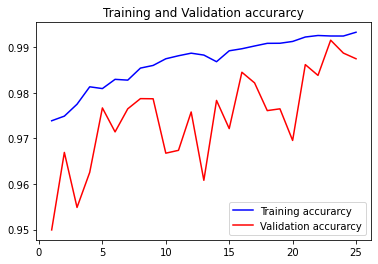

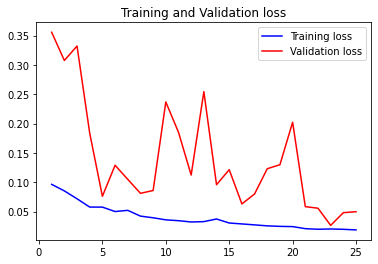

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the `evaluate` method

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
780/780 [==============================] - 52s 66ms/step
Test Accuracy: 98.74754548072815


# Save Model

In [ ]:
# Dump pickle file of the model
print("[INFO] Saving model...")
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...


In [ ]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


# Test Model


We write the following `predict_disease` function to predict the class or disease of a plant image. 

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [1]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

For testing purposes, we randomly choose images from the dataset and try predicting class or disease of the plant image.

In [2]:
predict_disease('/content/PlantVillage/val/Blueberry___healthy/008c85d0-a954-4127-bd26-861dc8a1e6ff___RS_HL 2431.JPG')

NameError: ignored

In [ ]:
predict_disease('/content/PlantVillage/val/Potato___Early_blight/03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG')

In [ ]:
predict_disease('/content/PlantVillage/val/Tomato___Target_Spot/1006b3dd-22d8-41b8-b83d-08bf189fcdaa___Com.G_TgS_FL 8118.JPG')

In [ ]:
predict_disease('/content/PlantVillage/val/Orange___Haunglongbing_(Citrus_greening)/02459e0c-a189-4dc9-a0dc-0548e36d0efb___CREC_HLB 5714.JPG')